In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_fscore_support, accuracy_score, precision_recall_curve)
from sklearn.manifold import TSNE
from lightgbm import LGBMClassifier
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# ---------- Load and Clean ----------
def load_and_clean(path):
    df = pd.read_csv(path)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df.dropna()

# Load datasets
benign = pd.concat([
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign.csv"),
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign1.csv"),
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign2.csv"),
    load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Benign3.csv")
], ignore_index=True)

# Attack datasets
sqlInj = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/SqlInjection.csv")
uploading = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Uploading_Attack.csv")
portscan = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Recon-PortScan.csv")
Backdoor_Malware = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Backdoor_Malware.csv")
BrowserHijacking = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/BrowserHijacking.csv")
DDoS_SlowLoris = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/DDoS-SlowLoris.csv")
DNS_Spoofing = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/DNS_Spoofing.csv")
Recon_OSScan = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/Recon-OSScan.csv")
VulnerabilityScan = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/VulnerabilityScan.csv")
XSS = load_and_clean("/home/user/ml_Mastery/GitHub-WS/Hybrid (unsupervised with supervised) NIDS/DS/XSS.csv")

common_cols = list(set(benign.columns) & set(uploading.columns) & set(sqlInj.columns) & set(portscan.columns) &  set(Backdoor_Malware.columns) & set(BrowserHijacking.columns) & set(DDoS_SlowLoris.columns)  &  set(Recon_OSScan.columns) & set(VulnerabilityScan.columns)  &  set(XSS.columns) )
if "Label" in common_cols:
    common_cols.remove("Label")



When to use fit_transform() vs. transform()

fit_transform()	Training data (e.g., benign)	Learns the transformation (fit) and then applies it
transform()	Test/attack/other datasets	Just applies the learned transformation — no learning happens

In [4]:
X_benign = benign[common_cols] # get only common_cols from dataset cvs
X_upload = uploading[common_cols]
X_sqlInj = sqlInj[common_cols]
X_portscan = portscan[common_cols]

X_Backdoor_Malware = Backdoor_Malware[common_cols]
X_BrowserHijacking = BrowserHijacking[common_cols]
X_DDoS_SlowLoris = DDoS_SlowLoris[common_cols]
X_DNS_Spoofing = DNS_Spoofing[common_cols]
X_Recon_OSScan = Recon_OSScan[common_cols] 
X_VulnerabilityScan = VulnerabilityScan[common_cols]
X_XSS = XSS[common_cols]



scaler = StandardScaler()
X_benign_scaled = scaler.fit_transform(X_benign)

X_upload_scaled = scaler.transform(X_upload)
X_sqlInj_scaled = scaler.transform(X_sqlInj)
X_portscan_scaled = scaler.transform(X_portscan)

X_Backdoor_Malware_scaled = scaler.transform(X_Backdoor_Malware)
X_BrowserHijacking_scaled = scaler.transform(X_BrowserHijacking)
X_DDoS_SlowLoris_scaled = scaler.transform(X_DDoS_SlowLoris)
X_DNS_Spoofing_scaled = scaler.transform(X_DNS_Spoofing)
X_Recon_OSScan_scaled = scaler.transform(X_Recon_OSScan)

# Clip all values to a range, e.g., [-1e10, 1e10]
X_VulnerabilityScan = X_VulnerabilityScan.clip(-1e10, 1e10) #If your dataset has legitimate but extreme values, you can clip them to a reasonable range:
# Also replace inf just in case
X_VulnerabilityScan.replace([np.inf, -np.inf], np.nan, inplace=True)
X_VulnerabilityScan.dropna(inplace=True)

X_VulnerabilityScan_scaled = scaler.transform(X_VulnerabilityScan)

X_XSS_scaled = scaler.transform(X_XSS)


In [5]:
import torch

# Convert NumPy arrays to float32 tensors
X_benign_tensor = torch.tensor(X_benign_scaled, dtype=torch.float32)
X_upload_tensor = torch.tensor(X_upload_scaled, dtype=torch.float32)
X_sqlInj_tensor = torch.tensor(X_sqlInj_scaled, dtype=torch.float32)
X_portscan_tensor = torch.tensor(X_portscan_scaled, dtype=torch.float32)


X_Backdoor_Malware_tensor = torch.tensor(X_Backdoor_Malware_scaled, dtype=torch.float32)
X_BrowserHijacking_tensor = torch.tensor(X_BrowserHijacking_scaled, dtype=torch.float32)
X_DDoS_SlowLoris_tensor = torch.tensor(X_DDoS_SlowLoris_scaled, dtype=torch.float32)
X_DNS_Spoofing_tensor = torch.tensor(X_DNS_Spoofing_scaled, dtype=torch.float32)
X_Recon_OSScan_tensor = torch.tensor(X_Recon_OSScan_scaled, dtype=torch.float32)
X_VulnerabilityScan_tensor = torch.tensor(X_VulnerabilityScan_scaled, dtype=torch.float32)
X_XSS_tensor = torch.tensor(X_XSS_scaled, dtype=torch.float32)


In [6]:
# ---------- Define AE with Attention ----------
class AEWithAttention(nn.Module):
    def __init__(self, input_dim, bottleneck_dim=32):
        super().__init__()
        self.feature_attention = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.Sigmoid()
        )
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, bottleneck_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        attn_weights = self.feature_attention(x)
        x_weighted = x * attn_weights
        encoded = self.encoder(x_weighted)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [7]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1, Loss: 0.022334
Epoch 2, Loss: 0.002057
Epoch 3, Loss: 0.001350
Epoch 4, Loss: 0.001105
Epoch 5, Loss: 0.001195
Epoch 6, Loss: 0.001177
Epoch 7, Loss: 0.000892
Epoch 8, Loss: 0.000742
Epoch 9, Loss: 0.000671
Epoch 10, Loss: 0.000565
Epoch 11, Loss: 0.000673
Epoch 12, Loss: 0.000514
Epoch 13, Loss: 0.000487
Epoch 14, Loss: 0.000433
Epoch 15, Loss: 0.000452
Epoch 16, Loss: 0.000413
Epoch 17, Loss: 0.000424
Epoch 18, Loss: 0.000558
Epoch 19, Loss: 0.000627
Epoch 20, Loss: 0.000496


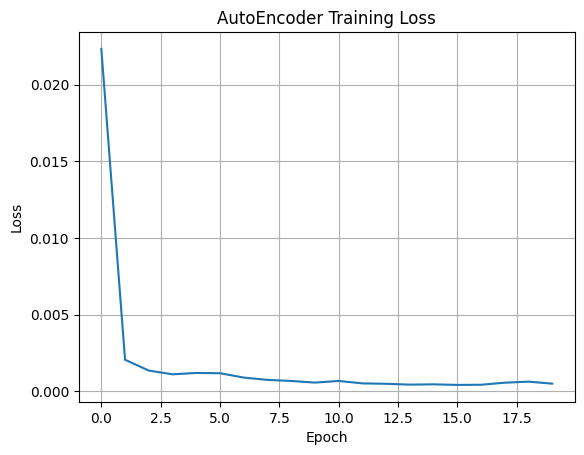

In [8]:
input_dim = X_benign_scaled.shape[1]
model = AEWithAttention(input_dim)
model.to(device)  # Move model to GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

X_benign_tensor = torch.tensor(X_benign_scaled, dtype=torch.float32) # convert to tensor
dataloader = DataLoader(TensorDataset(X_benign_tensor), batch_size=128, shuffle=True)

train_losses = []
for epoch in range(20):
    model.train()
    epoch_loss = 0
    for x_batch, in dataloader:
        optimizer.zero_grad()
        x_batch = x_batch.to(device)
        recon, _ = model(x_batch)
        loss = criterion(recon, x_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.6f}")

plt.plot(train_losses)
plt.title("AutoEncoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [9]:
# ---------- Feature Extraction ----------
#This function takes your scaled input data (like benign or attack samples) and passes it through your trained AutoEncoder model.
def extract_ae_features(X_scaled):
    with torch.no_grad(): #You tell PyTorch not to track gradients here because you're not training, just using the model to get outputs. This makes it faster and uses less memory.
        tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)  # #Converts  NumPy array (X_scaled) into a PyTorch tensor so the model can use it.
        model.eval()  # Just in case
       
        #Run through the AutoEncoder 
        #This gets:
            #embed: the compressed version of the input (what the encoder learned)
            #recon: the model’s attempt to reconstruct the original input
        recon, embed = model(tensor) 
        loss = torch.mean((tensor - recon)**2, dim=1).unsqueeze(1) #You compute the reconstruction error (how far off the model was from the original): For each sample, it’s the mean squared difference
        #embed alone → can be used for t-SNE or clustering, loss alone → can be used for anomaly detection
        return torch.cat([embed, loss], dim=1).cpu().numpy(), embed.cpu().numpy(), loss.cpu().numpy() # embed + loss → a feature vector that combines what the AutoEncoder learned and how well it reconstructed

#Now you apply it to different traffic types:
#Each dataset (benign, upload, SQLi, portscan) gets:
    #X_*_final: the [embed + loss] features
    #E_*: just embedding
    #L_*: just reconstruction loss

X_benign_final, E_benign, L_benign = extract_ae_features(X_benign_scaled)
X_upload_final, E_upload, L_upload = extract_ae_features(X_upload_scaled)
X_sqlInj_final, E_sqlInj, L_sqlInj = extract_ae_features(X_sqlInj_scaled)
X_portscan_final, E_portscan, L_portscan = extract_ae_features(X_portscan_scaled)

X_Backdoor_Malware_final, E_Backdoor_Malware, L_Backdoor_Malware = extract_ae_features(X_Backdoor_Malware_scaled)
X_BrowserHijacking_final, E_BrowserHijacking, L_BrowserHijacking = extract_ae_features(X_BrowserHijacking_scaled)
X_DDoS_SlowLoris_final, E_DDoS_SlowLoris, L_DDoS_SlowLoris = extract_ae_features(X_DDoS_SlowLoris_scaled)
X_DNS_Spoofing_final, E_DNS_Spoofing, L_DNS_Spoofing = extract_ae_features(X_DNS_Spoofing_scaled)
X_Recon_OSScan_final, E_Recon_OSScan, L_Recon_OSScan = extract_ae_features(X_Recon_OSScan_scaled)
X_VulnerabilityScan_final, E_VulnerabilityScan, L_VulnerabilityScan = extract_ae_features(X_VulnerabilityScan_scaled)
X_XSS_final, E_XSS, L_XSS = extract_ae_features(X_XSS_scaled)




X_final = np.vstack([X_benign_final, X_upload_final, X_sqlInj_final, X_portscan_final, X_Backdoor_Malware_final, X_BrowserHijacking_final, X_DDoS_SlowLoris_final, X_DNS_Spoofing_final, X_Recon_OSScan_final, X_VulnerabilityScan_final,X_XSS_final ]) # Now X_final contains all features (from all traffic types), ready for classification.
#You label the data:
    #0 → benign
    #1 → upload attack
    #2 → SQL injection
    #3 → portscan
    #.
    #..
    #.n

y_final = np.array([0]*len(X_benign_final) + [1]*len(X_upload_final) + [2]*len(X_sqlInj_final) + [3]*len(X_portscan_final)+  [4]*len(X_Backdoor_Malware_final)+  [5]*len(X_BrowserHijacking_final)+  [6]*len(X_DDoS_SlowLoris_final)+ [7]*len(X_DNS_Spoofing_final)+ [8]*len(X_Recon_OSScan_final)+  [9]*len(X_VulnerabilityScan_final)+   [10]*len(X_XSS_final) )

#fix class imbalance 

In [10]:
import pandas as pd
import numpy as np

#df = pd.DataFrame(X_final)
#df['label'] = y_final

#grouped = [group for _, group in df.groupby('label')]
#min_size = min(len(g) for g in grouped)
#balanced_groups = [g.sample(min_size, random_state=42) for g in grouped]

#balanced_df = pd.concat(balanced_groups).sample(frac=1, random_state=42)
#X_balanced = balanced_df.drop('label', axis=1).values
#y_balanced = balanced_df['label'].values

OR

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_final, y_final)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

model = LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 9663508, number of used features: 33
[LightGBM] [Info] Start training from score -2.397903
[LightGBM] [Info] Start training from score -2.397576
[LightGBM] [Info] Start training from score -2.398083
[LightGBM] [Info] Start training from score -2.397807
[LightGBM] [Info] Start training from score -2.397569
[LightGBM] [Info] Start training from score -2.398108
[LightGBM] [Info] Start training from score -2.397493
[LightGBM] [Info] Start training from score -2.397755
[LightGBM] [Info] Start training from score -2.398920
[LightGBM] [Info] Start training from score -2.398258
[LightGBM] [Info] Start training from score -2.397376
              precision    recall  f1-score   suppo

In [13]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# ---------- LightGBM Training ----------
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, stratify=y_final, test_size=0.2)
clf = LGBMClassifier(objective='multiclass', num_class=4)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print("F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_test, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8415
[LightGBM] [Info] Number of data points in the train set: 9663508, number of used features: 33
[LightGBM] [Info] Start training from score -2.397903
[LightGBM] [Info] Start training from score -2.397576
[LightGBM] [Info] Start training from score -2.398083
[LightGBM] [Info] Start training from score -2.397807
[LightGBM] [Info] Start training from score -2.397569
[LightGBM] [Info] Start training from score -2.398108
[LightGBM] [Info] Start training from score -2.397493
[LightGBM] [Info] Start training from score -2.397755
[LightGBM] [Info] Start training from score -2.398920
[LightGBM] [Info] Start training from score -2.398258
[LightGBM] [Info] Start training from score -2.397376
              precision    recall  f1-score   suppo

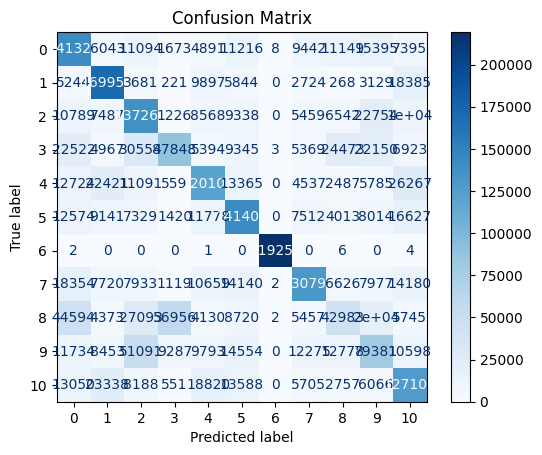

In [14]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits=2))


              precision    recall  f1-score   support

           0       0.48      0.64      0.55    219632
           1       0.64      0.77      0.70    219345
           2       0.46      0.62      0.53    219790
           3       0.55      0.40      0.46    219548
           4       0.59      0.55      0.57    219339
           5       0.59      0.64      0.61    219812
           6       1.00      1.00      1.00    219272
           7       0.69      0.60      0.64    219502
           8       0.38      0.19      0.26    220525
           9       0.42      0.36      0.39    219944
          10       0.52      0.58      0.55    219169

    accuracy                           0.58   2415878
   macro avg       0.57      0.58      0.57   2415878
weighted avg       0.57      0.58      0.57   2415878



In [16]:
import numpy as np
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 219632, 1: 219345, 2: 219790, 3: 219548, 4: 219339, 5: 219812, 6: 219272, 7: 219502, 8: 220525, 9: 219944, 10: 219169}


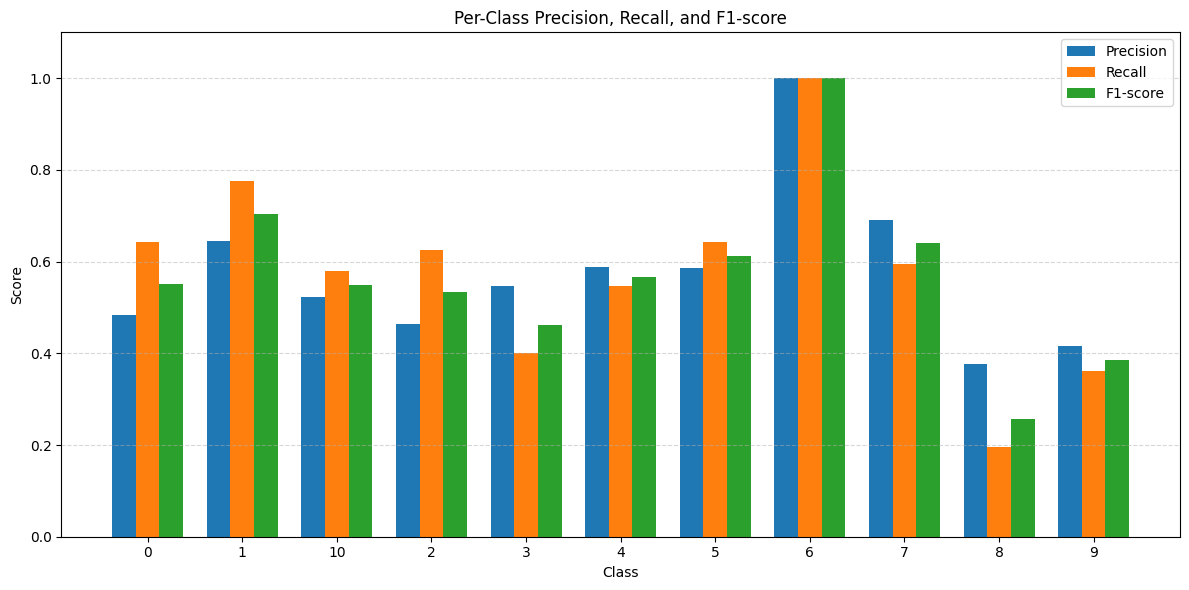

In [17]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get predictions (example)
# y_pred = model.predict(X_test)

# Step 2: Generate report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Step 3: Extract precision, recall, f1-score for each class
labels = sorted([str(i) for i in np.unique(y_test)])  # class labels as strings
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1 = [report[label]['f1-score'] for label in labels]

# Step 4: Plot
x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')

plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Per-Class Precision, Recall, and F1-score')
plt.xticks(x, labels)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


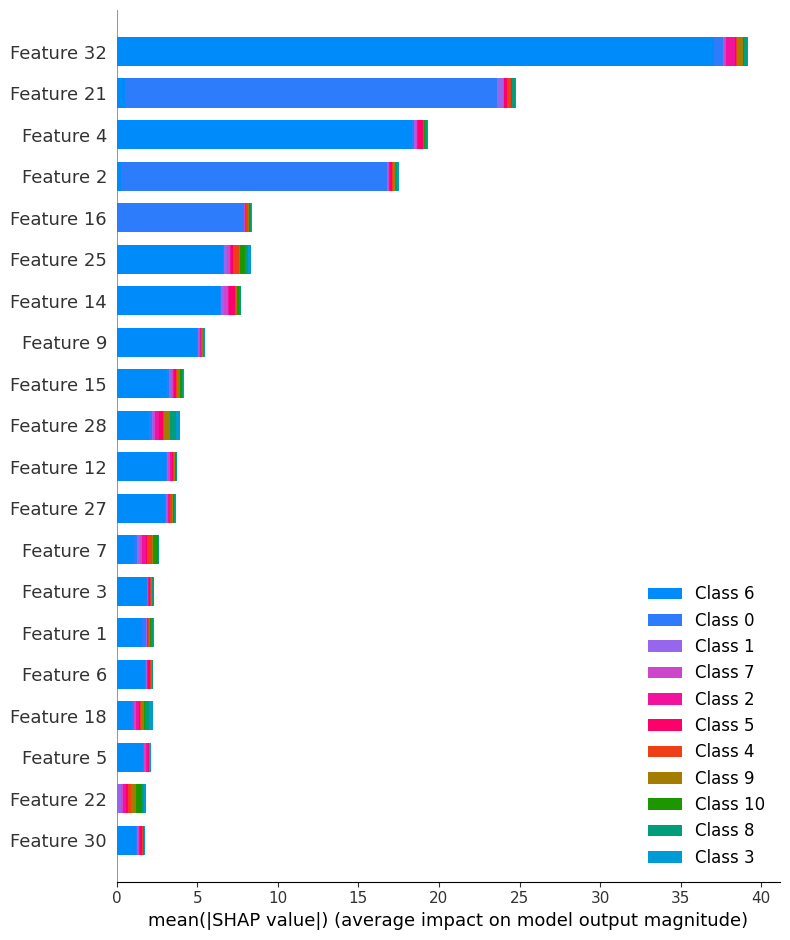

In [18]:
# ---------- Export Predictions ----------
pd.DataFrame({"y_true": y_test, "y_pred": y_pred}).to_csv("AE_LightGBM_Predictions.csv", index=False)

# ---------- SHAP Summary Plot ----------
shap.initjs()
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

# ---------- t-SNE Embeddings ----------
embeddings = np.vstack([E_benign, E_upload, E_sqlInj, E_portscan])
labels = np.array([0]*len(E_benign) + [1]*len(E_upload) + [2]*len(E_sqlInj) + [3]*len(E_portscan))

from sklearn.utils import resample
# Sample 2000 points for faster visualization
embeddings_sampled, labels_sampled = resample(embeddings, labels, n_samples=2000, stratify=labels, random_state=42)

tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(embeddings_sampled)

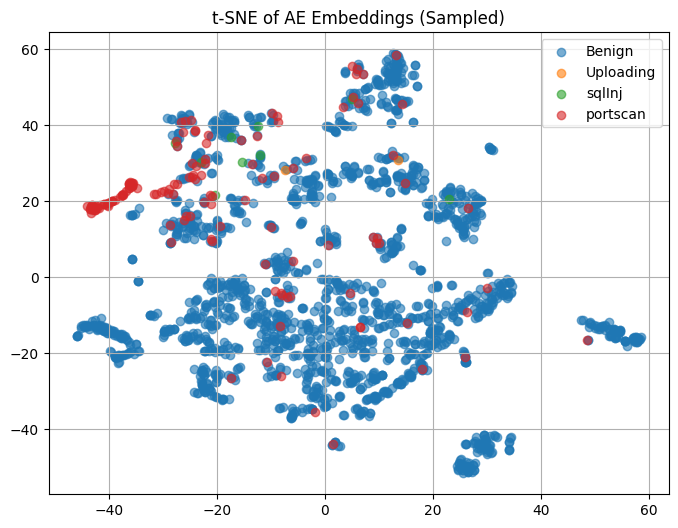

In [19]:
plt.figure(figsize=(8,6))
class_names = ['Benign', 'Uploading', 'sqlInj', 'portscan']

for i, name in enumerate(class_names):
    plt.scatter(reduced[labels_sampled == i, 0], reduced[labels_sampled == i, 1], label=name, alpha=0.6)

plt.legend()
plt.title("t-SNE of AE Embeddings (Sampled)")
plt.grid(True)
plt.show()

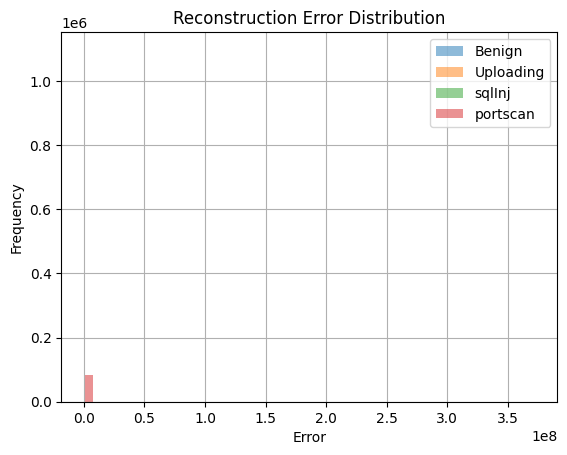

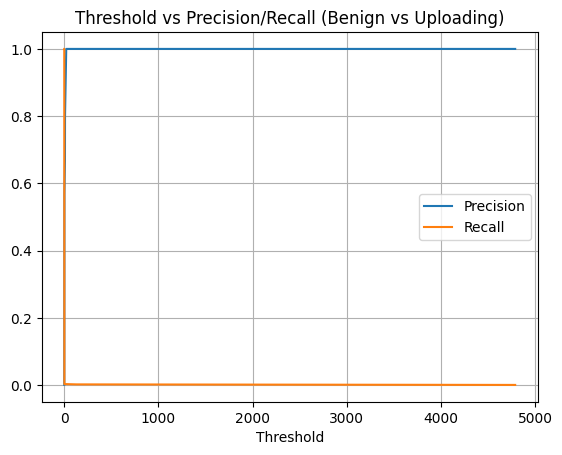

In [20]:
# ---------- Reconstruction Error Dist ----------
plt.hist(L_benign, bins=50, alpha=0.5, label="Benign")
plt.hist(L_upload, bins=50, alpha=0.5, label="Uploading")
plt.hist(L_sqlInj, bins=50, alpha=0.5, label="sqlInj")
plt.hist(L_portscan, bins=50, alpha=0.5, label="portscan")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Threshold Tuning ----------
recon_errors = np.vstack([L_benign, L_upload]).flatten()
labels_binary = np.array([0]*len(L_benign) + [1]*len(L_upload))
prec, rec, thresholds = precision_recall_curve(labels_binary, recon_errors)

plt.plot(thresholds, prec[:-1], label="Precision")
plt.plot(thresholds, rec[:-1], label="Recall")
plt.title("Threshold vs Precision/Recall (Benign vs Uploading)")
plt.xlabel("Threshold")
plt.grid(True)
plt.legend()
plt.show()